In [4]:
from ngsolve import *
#from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from netgen.geom2d import SplineGeometry

#l is number of meshwidths, the n-th meshwidth is 1/(2^(n-1))
l = 6
meshwidths = np.ones(l)
for h in range(l-1):
    meshwidths[h+1] = meshwidths[h]/2

print(meshwidths)
#order for which the elements corresponds to the whitney forms H1,HCurl = 1, HDiv,L2 = 0
lowest_low_order = 0
# amount of orders for the low-Order space (set to 1 if not interested in higher low orders)
low_orders = 1
# largest low order to test
highest_low_order = lowest_low_order + low_orders

#amount of orders for the high-Order space
high_orders = 4 
#array storing the minimal Eigenvalue for given orders and meshwidth
minEV = np.zeros((low_orders,high_orders,l))

for j in range(lowest_low_order , highest_low_order):
    #high order needs to be greater than low order
    lowest_high_Order = j + 1
    #largest high order to test
    highest_high_order = lowest_high_Order + high_orders
    
    for k in range(l):
        #reset mesh, for new constant meshwidth
        netgen_mesh = unit_square.GenerateMesh(maxh=1)
        mesh=Mesh(netgen_mesh)
        for mw in range(k):
            mesh.Refine()

        #Draw(mesh)

        print("meshwidth:",meshwidths[k],"polynomal order of low order space:", j)
              
        #actual meshwidth
        elvol = Integrate(CoefficientFunction(1),mesh,element_wise=True)
        mesh_h = [(2*vol)**(1/2) for vol in elvol]
        print("actual meshwidth range",min(mesh_h),max(mesh_h), "\n")

        for i in range(lowest_high_Order, highest_high_order):
            print("polynomal order of high order space =",i)

            #set function space, for l=0 its normal lagrangian finite elements
            #need to compress to remove DOFs of unrefined mesh after refinement
            H_h = Compress(HDiv(mesh, order = j, RT=True ,complex=False)) # main function space
            H_H = Compress(HDiv(mesh, order = i, RT=True ,complex=False)) # high order Function space for Riesz representative  

            print("# DoFs of low order space:", H_h.ndof, ", # DoFs of high order space:", H_H.ndof)

            #low order
            u_h = H_h.TrialFunction() # define the trial function
            v_h = H_h.TestFunction() # define the test function
            #High order
            u_H = H_H.TrialFunction() # define the trial function
            v_H= H_H.TestFunction() # define the test function

            m = BilinearForm(H_h, symmetric=True, symmetric_storage=True) #define m with the L2 inner product on the low order space
            m += u_h*v_h * dx 
            m.Assemble()

            a = BilinearForm(H_H, symmetric=True, symmetric_storage=True) # define the HDiv inner product on the high order space
            a += div(u_H) * div(v_H) * dx
            a += u_H*v_H * dx 
            a.Assemble()

            #mass matrix with mixed basis functions
            a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
            a_mixed += u_h*v_H*dx
            a_mixed.Assemble()

            #compute inverses 
            a_inv = a.mat.Inverse()
            m_inv = m.mat.Inverse()

            #create Matrices for GEV problem

            #c is the low order galerkin matrix
            c = BilinearForm(H_h, symmetric=True, symmetric_storage=False)
            c += div(u_h) * div(v_h) * dx
            c += u_h*v_h * dx 
            c.Assemble()

            # b is the Matrix that lets us compute the norm of the Riesz representative
            # m==m.t, m_inv == m_inv.T
            b = c.mat.T @m_inv @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_inv @ c.mat
            B = b.ToDense().NumPy()

            #C = c.mat.ToDense().NumPy()
            rows,cols,vals = c.mat.COO()
            C = sp.sparse.csr_matrix((vals,(rows,cols)))

            #The matrices Involved are Symmetric, so the symmetric solver is used
            #look for largest Eigenvalue of Bx = λCx, since ARPACK is more efficient for large EV's
            lam = sp.sparse.linalg.eigsh(B, k=1, M=C, which='LM', return_eigenvectors=False)
            print(lam)
            #if FEM space is complex need to take absolut value (the EV's have no imaginary part, but are still datatype complex)        
            #lam = np.abs(lam)
            #1/λ is the smallest EV of Cx = λBX
            minEV[j-lowest_low_order,i-lowest_high_Order,k] = 1/lam[0]

            print("\n")

print(minEV)

[1.      0.5     0.25    0.125   0.0625  0.03125]
meshwidth: 1.0 polynomal order of low order space: 0
actual meshwidth range 0.999999999999998 0.9999999999999981 

polynomal order of high order space = 1
# DoFs of low order space: 5 , # DoFs of high order space: 14
[9.81632653]


polynomal order of high order space = 2
# DoFs of low order space: 5 , # DoFs of high order space: 27
[19.55080141]


polynomal order of high order space = 3
# DoFs of low order space: 5 , # DoFs of high order space: 44
[19.86791647]


polynomal order of high order space = 4
# DoFs of low order space: 5 , # DoFs of high order space: 65
[19.93515753]


meshwidth: 0.5 polynomal order of low order space: 0
actual meshwidth range 0.499999999999999 0.49999999999999917 

polynomal order of high order space = 1
# DoFs of low order space: 16 , # DoFs of high order space: 48
[36.8134715]


polynomal order of high order space = 2
# DoFs of low order space: 16 , # DoFs of high order space: 96
[75.70884867]


polynomal o

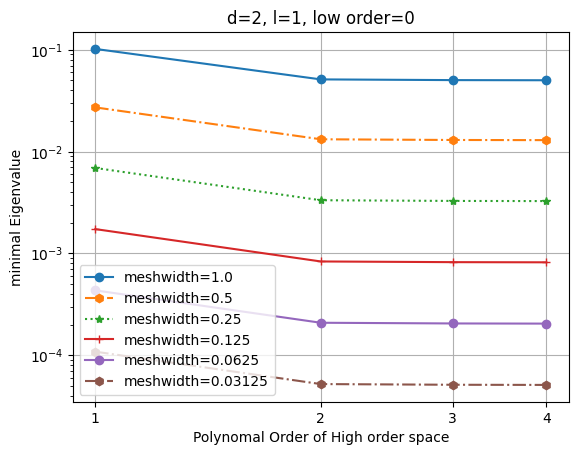

In [6]:
symbols = ['o-','h-.','*:','+-']

#minimal Ev
for j in range(lowest_low_order, highest_low_order):
    
    lowest_high_Order = j + 1
    highest_high_order = lowest_high_Order + high_orders
    orders = np.arange(lowest_high_Order, highest_high_order)
    
    fig, ax = plt.subplots()
    plt.grid(visible=True)
    plt.title(label="d=2, l=1, low order=%i" %j)
    #plt.loglog(orders,np.ones(high_orders) * 0.5,'--k', label="0.5")
    plt.xlabel('Polynomal Order of High order space')

    plt.ylabel('minimal Eigenvalue')

    for k in range(l):
        plt.loglog(orders,minEV[j-lowest_low_order,:,k], symbols[k%4], label="meshwidth={d}".format(d=meshwidths[k]))

    plt.xticks(orders,orders.astype(str))
    plt.legend()
    plt.show()

